In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
from numpy import mean
from numpy import isnan
from numpy import asarray
from numpy import polyfit
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from plotly.offline.offline import plot

In [ ]:
#Loading in count and engraftment data
count_df = pd.read_csv('/content/drive/MyDrive/Penn_work/counts.cts', sep='\t')
engraftment_df = pd.read_csv('/content/drive/MyDrive/Penn_work/Engraftment_Sheet2.tsv', sep='\t')

In [ ]:
#Looking at subset of count data
count_df.head()

,Genes,14415-27,14415-20,14415-19,14415-33,14415-32,14415-23,14415-34,14415-29,14415-30.,...,14415-02,14415-03,14415-04,14415-07,14415-08,14415-09,14415-10,14415-11,14415-12,14415-13
0,A1BG,138,100,141,88,66,81,80,84,124,...,233,184,183,156,253,158,157,196,143,164
1,A1CF,2,1,2,2,0,1,2,1,5,...,3,5,0,8,2,5,0,4,0,1
2,A2M,3,1,3,8,8,10,3,7,21,...,1,12,3,4,5,6,2,6,0,3
3,A2ML1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,A3GALT2,1,2,4,1,0,2,1,0,0,...,1,6,0,1,4,2,0,1,0,0


In [ ]:
#Removing patients for which we do not have engraftment data
#Cohort 2 = '14415-22', '14415-12', '14415-13', '14415-14', '14415-16'
labeled_count_df = count_df.drop(['14415-30.', '14415-04', '14415-26'], axis=1)
labeled_count_df.head()

,Genes,14415-27,14415-20,14415-19,14415-33,14415-32,14415-23,14415-34,14415-29,14415-21,...,14415-17,14415-02,14415-03,14415-07,14415-08,14415-09,14415-10,14415-11,14415-12,14415-13
0,A1BG,138,100,141,88,66,81,80,84,78,...,245,233,184,156,253,158,157,196,143,164
1,A1CF,2,1,2,2,0,1,2,1,2,...,0,3,5,8,2,5,0,4,0,1
2,A2M,3,1,3,8,8,10,3,7,15,...,0,1,12,4,5,6,2,6,0,3
3,A2ML1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,A3GALT2,1,2,4,1,0,2,1,0,0,...,0,1,6,1,4,2,0,1,0,0


In [ ]:
engraftment_df['Lowercase_Engraftment'] = engraftment_df.Engraftment.str.lower() 
engraftment_df['Binarized Engraftment'] = engraftment_df.Lowercase_Engraftment.eq('h').mul(1)
engraftment_df.set_index('Patient', drop = True, inplace = True)
engraftment_df.head()

,Engraftment,Cohort,CAR_GIVEN,Lowercase_Engraftment,Binarized Engraftment
Patient,,,,,
14415-27,h,3,5.0,h,1
14415-20,h,3,5.0,h,1
14415-19,l,3,5.0,l,0
14415-33,h,3,5.0,h,1
14415-32,h,3,5.0,h,1


In [ ]:
#Printing ratio of low engraftment in engraftment dataframe
num_zeroes = engraftment_df['Binarized Engraftment'][engraftment_df['Binarized Engraftment'] == 0].count()
percent_zeroes = num_zeroes/len(engraftment_df)
print('Ratio of patients with low engraftment: %0.3f' %percent_zeroes)

Ratio of patients with low engraftment: 0.542


In [ ]:
#Standardizing data frame by rows (need to standardize before taking PCA)
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

standardized_df = mean_norm(labeled_count_df.iloc[:,1:])
standardized_df.head()

,14415-27,14415-20,14415-19,14415-33,14415-32,14415-23,14415-34,14415-29,14415-21,14415-22,...,14415-17,14415-02,14415-03,14415-07,14415-08,14415-09,14415-10,14415-11,14415-12,14415-13
0,-0.264270,-0.280881,-0.262051,-0.272915,-0.264946,-0.258595,-0.258684,-0.281366,-0.280675,-0.272830,...,-0.178093,-0.231947,-0.238205,-0.248883,-0.194750,-0.248048,-0.238486,-0.221387,-0.236745,-0.212476
1,-0.314714,-0.333951,-0.303858,-0.315597,-0.289851,-0.290072,-0.284065,-0.315809,-0.303810,-0.316670,...,-0.253590,-0.285202,-0.280142,-0.292371,-0.274909,-0.302190,-0.294873,-0.276450,-0.275233,-0.287469
2,-0.314343,-0.333951,-0.303557,-0.312619,-0.286833,-0.286531,-0.283740,-0.313319,-0.299853,-0.314265,...,-0.253590,-0.285665,-0.278502,-0.293546,-0.273951,-0.301836,-0.294154,-0.275876,-0.275233,-0.286549
3,-0.315456,-0.334487,-0.304158,-0.316590,-0.289851,-0.290465,-0.284716,-0.316224,-0.304419,-0.318007,...,-0.253590,-0.285897,-0.281314,-0.294721,-0.275548,-0.303959,-0.294873,-0.277310,-0.275233,-0.287929
4,-0.315085,-0.333415,-0.303256,-0.316094,-0.289851,-0.289678,-0.284390,-0.316224,-0.304419,-0.318007,...,-0.253590,-0.285665,-0.279908,-0.294428,-0.274271,-0.303252,-0.294873,-0.277310,-0.275233,-0.287929


In [ ]:
#Transposing data so that patients are rows and genes are columns (PCA maintains rows/patients)
def transpose(df, count_data = count_df):
  if 'Genes' in df.columns:
    df.drop('Genes', axis = 1, inplace = True)
  tranposed_data = df.T
  tranposed_data.columns = list(count_data['Genes'])
  return tranposed_data

prepped_data = transpose(standardized_df)
prepped_data.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
14415-27,-0.264270,-0.314714,-0.314343,-0.315456,-0.315085,-0.310634,-0.315456,0.014655,0.007979,-0.315456,...,0.127412,0.615159,-0.276139,-0.194539,-0.069542,-0.309892,-0.072509,0.957881,0.406708,-0.034676
14415-20,-0.280881,-0.333951,-0.333951,-0.334487,-0.333415,-0.332343,-0.333951,0.028432,0.061668,-0.334487,...,0.165665,0.754806,-0.274448,-0.168306,-0.026784,-0.325374,-0.084679,0.948863,0.443885,-0.025711
14415-19,-0.262051,-0.303858,-0.303557,-0.304158,-0.303256,-0.304158,-0.304459,0.114511,-0.056927,-0.304459,...,0.201133,0.933203,-0.262051,-0.175730,-0.045197,-0.293030,-0.099636,0.705521,0.435431,0.018867
14415-33,-0.272915,-0.315597,-0.312619,-0.316590,-0.316094,-0.313612,-0.316590,0.034301,-0.022278,-0.316590,...,0.182201,0.625902,-0.266463,-0.158267,-0.052057,-0.310634,-0.081339,0.714245,0.327124,-0.033197
14415-32,-0.264946,-0.289851,-0.286833,-0.289851,-0.289851,-0.288719,-0.289851,-0.030236,-0.012878,-0.289851,...,0.143344,0.641820,-0.257022,-0.171742,-0.095517,-0.284946,-0.073631,1.117655,0.447109,-0.008350


In [ ]:
#Dimensionality reduction, creating 24 PCA components
pca = PCA(n_components=24)
reduced_data = pca.fit_transform(prepped_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.



In [ ]:
pca_df = pd.DataFrame(reduced_data)
pca_df.index = prepped_data.index
pca_df = pca_df.add_prefix('PCA_')

fig = px.imshow(pca_df.iloc[:,:6], labels=dict(x="Dimensionally Reduced Genes", y="Patients"))
fig.show()

In [ ]:
len(pca.components_[23])

19266

In [ ]:
prepped_data.columns

Index([   'A1BG',    'A1CF',     'A2M',   'A2ML1', 'A3GALT2',  'A4GALT',
         'A4GNT',    'AAAS',    'AACS',   'AADAC',
       ...
        'ZWILCH',   'ZWINT',    'ZXDA',    'ZXDB',    'ZXDC',  'ZYG11A',
        'ZYG11B',     'ZYX',   'ZZEF1',    'ZZZ3'],
      dtype='object', length=19266)

In [ ]:
#rows are the pca components, columns are the genes, values are significance of genes for pca component
pca_components_genes = pd.DataFrame(pca.components_,columns=prepped_data.columns,index = pca_df.columns)
print(pca_components_genes)
#i is the pca component index
def individual_pca_heatmap(count_data, pca_gene_arr, lim, i):
  #if out limit it less than one, we are defining a threshold for the genes to pass
  if lim < 1:
    s = pca_gene_arr.iloc[i,:]
    top_genes = list(s[s > lim].index)
  #if our limit is greater than one, we are defining the number of genes to chose
  if lim > 1:
    top_genes = list(pca_gene_arr.iloc[i,:].nlargest(lim).index)
  top_genes_counts = count_data[count_data.Genes.isin(top_genes)]
  top_genes_counts.set_index('Genes', drop = True, inplace = True)
  plot_data = mean_norm(top_genes_counts)
  #print(plot_data)
  fig = px.imshow(plot_data, labels=dict(x="Patients", y="Genes"), title = 'PCA Component ' + str(i))
  fig.show()

individual_pca_heatmap(labeled_count_df, pca_components_genes, 15, 1)

            A1BG          A1CF       A2M     A2ML1   A3GALT2    A4GALT  \
PCA_0   0.001399  6.163734e-04  0.000577  0.000619  0.000625  0.000700   
PCA_1  -0.000749 -9.876720e-04 -0.000947 -0.000988 -0.000978 -0.001172   
PCA_2  -0.001377 -1.136798e-03 -0.001166 -0.001163 -0.001158 -0.000767   
PCA_3  -0.000152  9.154407e-05  0.000055  0.000098  0.000110  0.000298   
PCA_4   0.000569 -2.091341e-04 -0.000185 -0.000211 -0.000232 -0.000107   
PCA_5   0.000451  5.526588e-04  0.000531  0.000531  0.000516  0.000915   
PCA_6   0.000152 -3.611974e-04 -0.000488 -0.000409 -0.000419 -0.000304   
PCA_7  -0.000338  1.548056e-04  0.000219  0.000146  0.000139  0.000373   
PCA_8   0.000049 -4.406576e-04 -0.000503 -0.000458 -0.000442 -0.000407   
PCA_9   0.000639  3.016291e-07  0.000096  0.000041  0.000030  0.000186   
PCA_10  0.001331  7.088620e-04  0.000696  0.000664  0.000620  0.001000   
PCA_11  0.001505  2.733244e-04  0.000309  0.000288  0.000301  0.000292   
PCA_12  0.001703 -5.045753e-04 -0.0004

In [ ]:
#Combining PCA and Engraftment dataframes to get the patients in the same order
combined_pca_engraftment = pd.concat([pca_df, engraftment_df], axis = 1)
engraftment_labels = combined_pca_engraftment['Binarized Engraftment']

#Checking that the order of patients was not changed from the reduced_data after dfs were combined
combined_pca_engraftment.index == pca_df.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [ ]:
#Training an SVM on the data, using KFold
#Group KFold means that it splits by group (equal amount of each cohort in train and test)
#Stratified means that the ratio of 0 to 1's is maintained for train and test
clf = svm.SVC(kernel='rbf', C=1, random_state=42)
cv = StratifiedGroupKFold(n_splits=3)
#group = combined_pca_engraftment['Binarized Engraftment'].astype('str') + '_' +  combined_pca_engraftment['Cohort'].astype('str')
group = combined_pca_engraftment['Cohort']
scores = cross_val_score(clf, reduced_data, engraftment_labels, groups = group, cv=cv, scoring='accuracy')
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

for train_index, test_index in cv.split(reduced_data, engraftment_labels, group):
  print("TRAIN:", train_index, "TEST:", test_index)

[0.625      0.6        0.63636364]
0.62 accuracy with a standard deviation of 0.02
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 22 23] TEST: [12 15 16 17 18 19 20 21]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 12 14 15 16 17 18 19 20 21] TEST: [ 9 11 13 22 23]
TRAIN: [ 9 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [ 0  1  2  3  4  5  6  7  8 10 14]


In [ ]:
#Predicting labels for removed patients
clf = svm.SVC(kernel='rbf', C=1, random_state=42)
ideal_cv = LeaveOneOut()
group = list(combined_pca_engraftment['Cohort'])
one_out_predictions = cross_val_score(clf, reduced_data, engraftment_labels, groups = group, scoring='accuracy', cv=ideal_cv, n_jobs=-1)
accuracy_arr = one_out_predictions == engraftment_labels
count = np.count_nonzero(accuracy_arr)
print(count/len(engraftment_labels))

0.4166666666666667


In [ ]:
len(reduced_data[:, :3])

24

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

X = reduced_data[:, :3]
Y = engraftment_labels

model = svm.SVC(kernel='rbf', C=1, random_state=42)
clf = model.fit(X, Y)

z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

tmp = np.linspace(-5,5,30)
x,y = np.meshgrid(tmp,tmp)

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot3D(X[Y==0,0], X[Y==0,1], X[Y==0,2],'ob')
ax.plot3D(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr')
ax.plot_surface(x, y, z(x,y))
ax.view_init(30, 60)
plt.show()

In [ ]:
start = 0
step = 1
stop = len(engraftment_df)
index_tuples = [(n, min(n+step, stop)) for n in range(start, stop, step)]

clf = svm.SVC(kernel='rbf', C=1, random_state=42)
cv = StratifiedGroupKFold(n_splits=3)

index_one = 1
index_two = 15

#group = combined_pca_engraftment['Binarized Engraftment'].astype('str') + '_' +  combined_pca_engraftment['Cohort'].astype('str')
group = list(combined_pca_engraftment['Cohort'])
engraftment_labels = list(engraftment_labels)
print(len(engraftment_labels))

new_groups = list()
for i, x in enumerate(group):
  if i != index_one and i != index_two:
    new_groups.append(x)

new_engraftment_labels = list()
for i, x in enumerate(engraftment_labels):
  if i != index_one and i != index_two:
    new_engraftment_labels.append(x)

new_reduced_data = list()
for i, x in enumerate(reduced_data):
  if i != index_one and i != index_two:
    new_reduced_data.append(x)
  
scores = cross_val_score(clf, new_reduced_data, new_engraftment_labels, groups = new_groups, cv=cv, scoring='accuracy')
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf.fit(new_reduced_data, new_engraftment_labels)

# Get predictions on the test set
X_test = [reduced_data[index_one], reduced_data[index_two]]
y_test = [engraftment_labels[index_one], engraftment_labels[index_two]]
y_pred = clf.predict(X_test)
print(y_pred)
print(y_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

#y_pred = cross_val_predict(lasso, X, y, cv=3)

#for train_index, test_index in cv.split(new_reduced_data, new_engraftment_labels, new_groups):
 # print("TRAIN:", train_index, "TEST:", test_index)

#y_test = [reduced_data[index_one], reduced_data[index_two]]
#y_pred = clf.predict(y_test)
#print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

24
[0.57142857 0.6        0.6       ]
0.59 accuracy with a standard deviation of 0.01
[1 0]
[1, 0]
Accuracy: 1.000


>LogisticRegression: ideal=0.458, cv=0.493
>RidgeClassifier: ideal=0.333, cv=0.452
>SGDClassifier: ideal=0.542, cv=0.459
>PassiveAggressiveClassifier: ideal=0.500, cv=0.459
>KNeighborsClassifier: ideal=0.417, cv=0.632
>DecisionTreeClassifier: ideal=0.292, cv=0.421
>ExtraTreeClassifier: ideal=0.292, cv=0.324
>LinearSVC: ideal=0.458, cv=0.501
>SVC: ideal=0.542, cv=0.620
>GaussianNB: ideal=0.375, cv=0.387
>AdaBoostClassifier: ideal=0.417, cv=0.555
>BaggingClassifier: ideal=0.417, cv=0.469
>RandomForestClassifier: ideal=0.375, cv=0.493
>ExtraTreesClassifier: ideal=0.500, cv=0.565
>GaussianProcessClassifier: ideal=0.417, cv=0.487
>GradientBoostingClassifier: ideal=0.250, cv=0.421
>LinearDiscriminantAnalysis: ideal=0.583, cv=0.632
>QuadraticDiscriminantAnalysis: ideal=0.458, cv=0.440
Correlation: 0.649


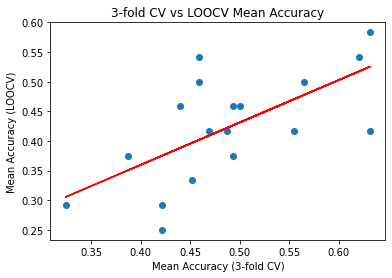

In [ ]:
#Finding correlation between test harness and ideal test condition

# get a list of models to evaluate
def get_models():
	models = list()
	models.append(LogisticRegression())
	models.append(RidgeClassifier())
	models.append(SGDClassifier())
	models.append(PassiveAggressiveClassifier())
	models.append(KNeighborsClassifier())
	models.append(DecisionTreeClassifier())
	models.append(ExtraTreeClassifier())
	models.append(LinearSVC())
	models.append(SVC())
	models.append(GaussianNB())
	models.append(AdaBoostClassifier())
	models.append(BaggingClassifier())
	models.append(RandomForestClassifier())
	models.append(ExtraTreesClassifier())
	models.append(GaussianProcessClassifier())
	models.append(GradientBoostingClassifier())
	models.append(LinearDiscriminantAnalysis())
	models.append(QuadraticDiscriminantAnalysis())
	return models

# evaluate the model using a given test condition
def evaluate_model(cv, model, X, y, group):
	scores = cross_val_score(model, X, y, groups = group, scoring='accuracy', cv=cv, n_jobs=-1)
	return mean(scores)

# define test conditions
ideal_cv = LeaveOneOut()
cv = StratifiedGroupKFold(n_splits=3)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()
# evaluate each model
for model in models:
	# evaluate model using each test condition
	cv_mean = evaluate_model(cv, model, reduced_data, engraftment_labels, group)
	ideal_mean = evaluate_model(ideal_cv, model, reduced_data, engraftment_labels, group)
	# check for invalid results
	if isnan(cv_mean) or isnan(ideal_mean):
		continue
	# store results
	cv_results.append(cv_mean)
	ideal_results.append(ideal_mean)
	# summarize progress
	print('>%s: ideal=%.3f, cv=%.3f' % (type(model).__name__, ideal_mean, cv_mean))
# calculate the correlation between each test condition
corr, _ = pearsonr(cv_results, ideal_results)
print('Correlation: %.3f' % corr)
# scatter plot of results
plt.scatter(cv_results, ideal_results)
# plot the line of best fit
coeff, bias = polyfit(cv_results, ideal_results, 1)
line = coeff * asarray(cv_results) + bias
plt.plot(cv_results, line, color='r')
# label the plot
plt.title('3-fold CV vs LOOCV Mean Accuracy')
plt.xlabel('Mean Accuracy (3-fold CV)')
plt.ylabel('Mean Accuracy (LOOCV)')
# show the plot
plt.show()